In [1]:
!pip install kaggle

In [5]:
#Setting up kaggle API Key for easy access
!mkdir ~/.kaggle
!cp /kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists
chmod: cannot access '/root/.kaggle/kaggle.json': Not a directory


In [6]:
#Downloading the dataset from kaggle directly
!kaggle datasets download -d shivamb/machine-predictive-maintenance-classification

Dataset URL: https://www.kaggle.com/datasets/shivamb/machine-predictive-maintenance-classification
License(s): CC0-1.0
  0% 0.00/137k [00:00<?, ?B/s]
100% 137k/137k [00:00<00:00, 67.9MB/s]


In [7]:
#unzip dataset
!unzip -q /content/machine-predictive-maintenance-classification.zip -d /content/

In [40]:
#Import Necessary Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import ConfusionMatrixDisplay

#import dataset
df = pd.read_csv("/content/predictive_maintenance.csv")

In [41]:
#target features:
categorical_cols = ["Type", "Product ID", "Failure Type"]
numerical_cols = [
    "Air temperature [K]",
    "Process temperature [K]",
    "Rotational speed [rpm]",
    "Torque [Nm]",
    "Tool wear [min]",
]
#encoding categorical variables into numerical format
le_dict = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col + "_encoded"] = le.fit_transform(df[col])
    le_dict[col] = le


In [42]:
#Feature Selection:

feature_cols = numerical_cols + [col + "_encoded" for col in categorical_cols]
X = df[feature_cols].values
y_binary = df["Target"].values
y_multiclass = df["Failure Type_encoded"].values

mi_scores = mutual_info_classif(X, y_binary)
feature_importance = pd.DataFrame({"feature": feature_cols, "mi_score": mi_scores}).sort_values("mi_score", ascending=False)

#MI selection for features above threshhold
threshold = mi_scores.mean()
selected_features = feature_importance[feature_importance["mi_score"] > threshold]["feature"].tolist()
X = df[selected_features].values

In [43]:
#5-fold Cross Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
binary_predictions = np.zeros(len(df))
multiclass_predictions = np.zeros(len(df))
f1_scores = []

# Store F1 scores for each fold
f1_scores_binary = []
f1_scores_multiclass = []

In [44]:
#Train and Evaluate Models Using Cross-Validation
for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    X_train, X_val = X[train_idx], X[val_idx]
    y_train_binary, y_val_binary = y_binary[train_idx], y_binary[val_idx]
    y_train_multi, y_val_multi = y_multiclass[train_idx], y_multiclass[val_idx]

    # Binary Classification
    binary_model = XGBClassifier(random_state=42)
    binary_model.fit(X_train, y_train_binary)
    binary_pred = binary_model.predict(X_val)
    f1_scores_binary.append(f1_score(y_val_binary, binary_pred))
    binary_predictions[val_idx] = binary_pred

    # Multiclass Classification
    multi_model = XGBClassifier(random_state=42)
    multi_model.fit(X_train, y_train_multi)
    multiclass_predictions[val_idx] = multi_model.predict(X_val)

    # Store F1 score for multiclass
    f1_scores_multiclass.append(f1_score(y_val_multi, multiclass_predictions[val_idx], average='weighted'))


#Average F1 Scores and Classification Reports
average_f1_binary = np.mean(f1_scores_binary)
average_f1_multiclass = np.mean(f1_scores_multiclass)

print(f"Average Binary F1 Score: {average_f1_binary:.4f}")
print(f"Average Multiclass F1 Score: {average_f1_multiclass:.4f}")

# Print Classification Report for Binary Classification
print("\nBinary Classification Report:")
print(classification_report(y_binary, binary_predictions))

# Print Classification Report for Multi-Class Classification
print("Multi-Class Classification Report:")
print(classification_report(y_multiclass, multiclass_predictions))

Average Binary F1 Score: 0.9867
Average Multiclass F1 Score: 1.0000

Binary Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9661
           1       1.00      0.97      0.99       339

    accuracy                           1.00     10000
   macro avg       1.00      0.99      0.99     10000
weighted avg       1.00      1.00      1.00     10000

Multi-Class Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       112
           1       1.00      1.00      1.00      9652
           2       1.00      1.00      1.00        78
           3       1.00      1.00      1.00        95
           4       1.00      1.00      1.00        18
           5       1.00      1.00      1.00        45

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     100

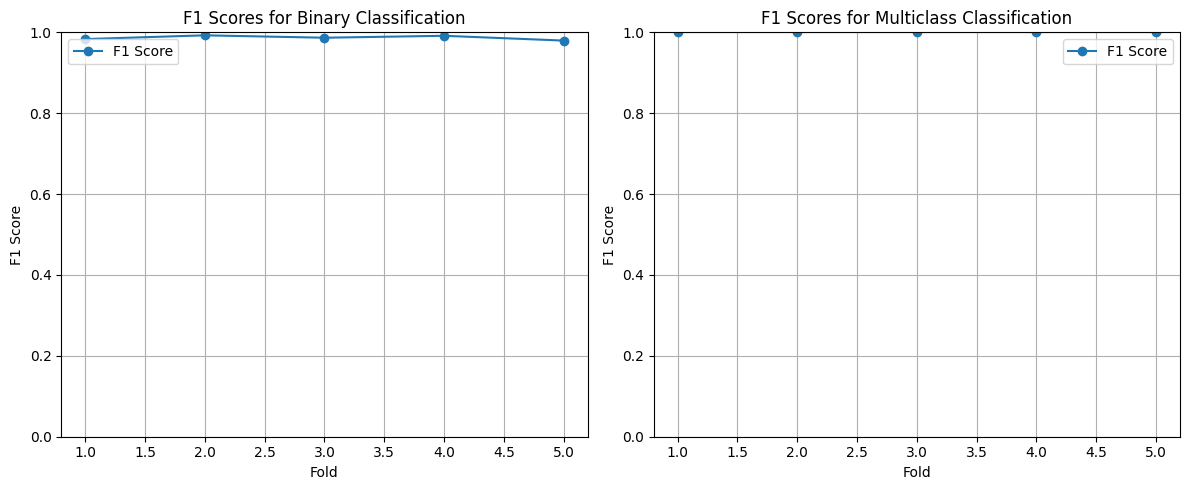

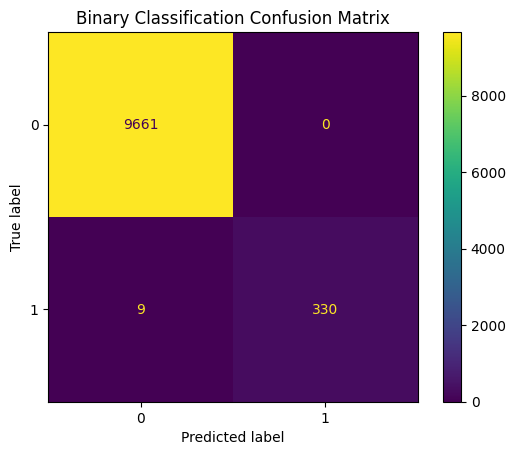

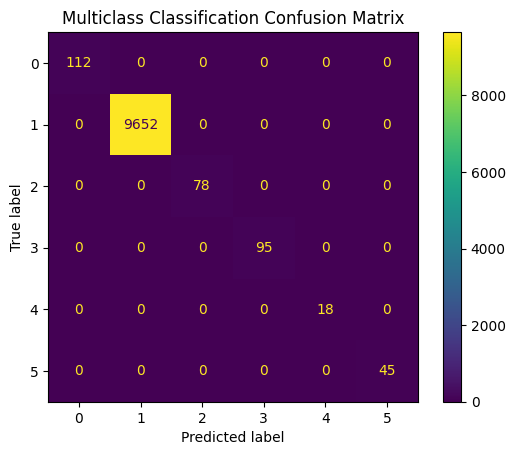

In [45]:
# Plotting F1 Scores
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, 6), f1_scores_binary, marker='o', label='F1 Score')
plt.title('F1 Scores for Binary Classification')
plt.xlabel('Fold')
plt.ylabel('F1 Score')
plt.ylim(0, 1)
plt.grid()
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, 6), f1_scores_multiclass, marker='o', label='F1 Score')
plt.title('F1 Scores for Multiclass Classification')
plt.xlabel('Fold')
plt.ylabel('F1 Score')
plt.ylim(0, 1)
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

# Confusion Matrix for Binary Classification
cm_binary = confusion_matrix(y_binary, binary_predictions)
ConfusionMatrixDisplay(confusion_matrix=cm_binary).plot()
plt.title('Binary Classification Confusion Matrix')
plt.show()

# Confusion Matrix for Multiclass Classification
cm_multi = confusion_matrix(y_multiclass, multiclass_predictions)
ConfusionMatrixDisplay(confusion_matrix=cm_multi).plot()
plt.title('Multiclass Classification Confusion Matrix')
plt.show()